In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Carregamento dos dados
dataset = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
# Convertendo as variáveis categóricas em variáveis dummy menos customerID
dataset_dummies = pd.get_dummies(dataset.drop('customerID', axis=1))

# Dividindo os dados em características e target
X = dataset_dummies.drop(['Churn_Yes', 'Churn_No'], axis=1)  # Características
y = dataset_dummies['Churn_Yes']  # Churn_Yes ja tem 0 e 1

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# XGBoost

In [4]:
# Configuração do modelo XGBoost
xg_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.5,
    colsample_bytree=0.5,
    objective='binary:logistic',
    random_state=42
)

In [5]:
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [6]:
predictions = xg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.8042553191489362
              precision    recall  f1-score   support

       False       0.84      0.91      0.87       511
        True       0.68      0.54      0.60       194

    accuracy                           0.80       705
   macro avg       0.76      0.72      0.74       705
weighted avg       0.80      0.80      0.80       705



# Rede neural

In [7]:
# Define the model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)), 
    Dropout(0.3), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3), 
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3), 
    Dense(1, activation='sigmoid') 
])

# Compile the model
nn_model.compile(optimizer='adam',
              loss= BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy'])

# Print the model summary
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               841728    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [8]:
# Convert data types
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
]

history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks)

Epoch 1/50
177/179 [============================>.] - ETA: 0s - loss: 1.3456 - accuracy: 0.7592
Epoch 1: val_loss improved from inf to 0.81458, saving model to best_model.h5
179/179 [==============================] - 3s 12ms/step - loss: 1.3423 - accuracy: 0.7588 - val_loss: 0.8146 - val_accuracy: 0.7997
Epoch 2/50
175/179 [============================>.] - ETA: 0s - loss: 0.7292 - accuracy: 0.7796
Epoch 2: val_loss improved from 0.81458 to 0.60335, saving model to best_model.h5
179/179 [==============================] - 2s 12ms/step - loss: 0.7279 - accuracy: 0.7800 - val_loss: 0.6033 - val_accuracy: 0.7981
Epoch 3/50
176/179 [============================>.] - ETA: 0s - loss: 0.5891 - accuracy: 0.7814
Epoch 3: val_loss improved from 0.60335 to 0.52158, saving model to best_model.h5
179/179 [==============================] - 2s 11ms/step - loss: 0.5901 - accuracy: 0.7807 - val_loss: 0.5216 - val_accuracy: 0.7997
Epoch 4/50
179/179 [==============================] - ETA: 0s - loss: 0.53

In [10]:
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
test_loss, test_acc = nn_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

23/23 [==============================] - 0s 4ms/step - loss: 0.4270 - accuracy: 0.8255
Test Accuracy: 0.8255318999290466


In [11]:
# Classification report
predictions = nn_model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
print(classification_report(y_test, predictions))

23/23 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88       511
         1.0       0.72      0.59      0.65       194

    accuracy                           0.83       705
   macro avg       0.79      0.75      0.77       705
weighted avg       0.82      0.83      0.82       705



# Ensemble

In [12]:
nn_predictions = nn_model.predict(X_test)[:, 0]  # Retorna a probabilidade da classe positiva
xgb_predictions = xg_model.predict_proba(X_test)[:, 1]  # Retorna a probabilidade da classe positiva

23/23 [==============================] - 0s 3ms/step


In [13]:
# Média das previsões
final_predictions = (nn_predictions + xgb_predictions) / 2

In [14]:
# Acurácia
final_class_predictions = (final_predictions > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, final_class_predictions))

Ensemble Accuracy: 0.8184397163120567


In [15]:
# Classification report
print(classification_report(y_test, final_class_predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       511
         1.0       0.71      0.58      0.64       194

    accuracy                           0.82       705
   macro avg       0.78      0.75      0.76       705
weighted avg       0.81      0.82      0.81       705



# Dataset desbalanceado

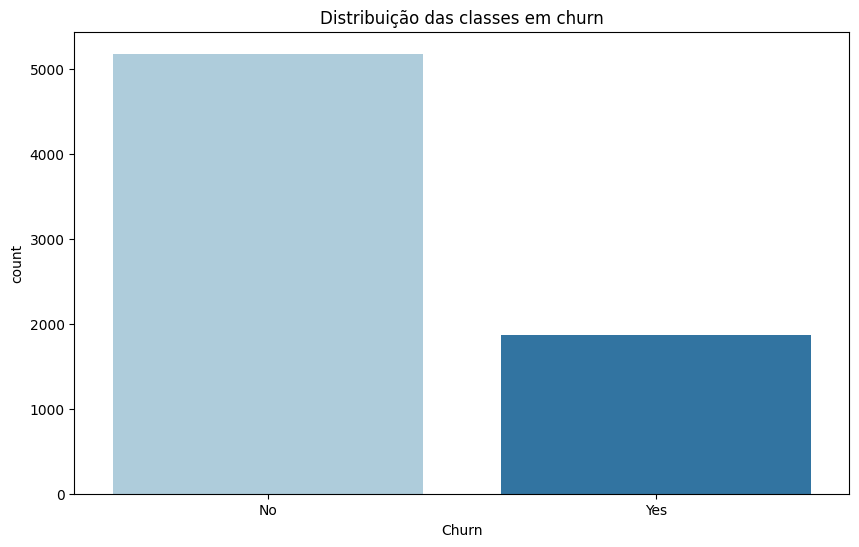

In [16]:
# Gráfico da Distribuição das classes em churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=dataset, palette='Paired', legend=False, hue='Churn')
plt.title('Distribuição das classes em churn')
plt.show()

A classificação desequilibrada é um problema comum no aprendizado de máquina, especialmente no domínio da classificação binária. Isso ocorre quando o conjunto de dados de treinamento tem uma distribuição desigual de classes, levando a um possível viés no modelo treinado. É importante abordar o desequilíbrio de classes para melhorar o desempenho do nosso modelo e garantir sua precisão.

## Modificando os Pesos na Função de Perda

A atribuição de pesos diferentes aos exemplos na função de perda pode ajudar a compensar o desequilíbrio. Isso significa dar maior importância aos exemplos da classe minoritária durante o treinamento do modelo.

**`(y_train == 1).sum()`**: Este trecho conta quantas vezes a classe `1` aparece no conjunto de dados de treino. Isso é feito comparando cada elemento de `y_train` com `1` (verdadeiro onde a condição é atendida) e somando esses valores verdadeiros.

**`(y_train == 0).sum()`**: Similarmente, este trecho conta quantas vezes a classe `0` aparece em `y_train`.

**Divisão**: A divisão do número de exemplos da classe minoritária (1) pelo número de exemplos da classe majoritária(0) calcula um fator de peso. Esse peso será usado para equilibrar as classes, aumentando a importância das instâncias da classe minoritária durante o treinamento do modelo.

In [17]:
# Calculando os pesos para cada classe
weights = (y_train == 1).sum() / (1.0 * (y_train == 0).sum())

xg_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.01, 
    max_depth=5,         # Quantidade de camadas, quanto mais camadas, mais complexo
    subsample=0.7,       # Quantidade de amostras por árvore, quanto menos amostras, mais rápido
    colsample_bytree=0.7,# Quantidade de colunas por árvore, quanto menos colunas, mais rápido
    reg_alpha=0.01,      # Regularização L1
    reg_lambda=1.0,      # Regularização L2
    objective='binary:logistic',
    random_state=42,
    scale_pos_weight=weights
)

# Treinamento do modelo
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [19]:
predictions = xg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.775886524822695
              precision    recall  f1-score   support

         0.0       0.77      0.99      0.86       511
         1.0       0.86      0.22      0.35       194

    accuracy                           0.78       705
   macro avg       0.81      0.60      0.61       705
weighted avg       0.79      0.78      0.72       705



In [20]:
nn_predictions = nn_model.predict(X_test)[:, 0]  # Retorna a probabilidade da classe positiva
xgb_predictions = xg_model.predict_proba(X_test)[:, 1]  # Retorna a probabilidade da classe positiva

# Média das previsões
final_predictions = (nn_predictions + xgb_predictions) / 2

# Acurácia
final_class_predictions = (final_predictions > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, final_class_predictions))

23/23 [==============================] - 0s 3ms/step
Ensemble Accuracy: 0.7957446808510639


In [21]:
# Classification report
print(classification_report(y_test, final_class_predictions))

              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87       511
         1.0       0.77      0.37      0.50       194

    accuracy                           0.80       705
   macro avg       0.79      0.66      0.68       705
weighted avg       0.79      0.80      0.77       705



### Análise de Classe
- **Classe 0 (Majoritária)**
  - **Precisão**: 0.80. Isso indica que 80% das previsões para classe 0 estão corretas.
  - **Recall**: 0.96. Significa que 96% das instâncias reais de classe 0 foram identificadas corretamente pelo modelo.
  - **F1-Score**: 0.87. O F1-score é uma média harmônica de precisão e recall, e um valor de 0.87 sugere um bom equilíbrio entre precisão e recall para esta classe.
  - **Suporte**: 511. Número total de casos reais da classe 0 no conjunto de teste.

- **Classe 1 (Minoritária)**
  - **Precisão**: 0.77. Isto sugere que 77% das previsões de classe 1 pelo modelo estão corretas.
  - **Recall**: 0.37. Apenas 37% das instâncias reais de classe 1 foram identificadas corretamente, o que é bastante baixo.
  - **F1-Score**: 0.50. Este valor mais baixo indica uma baixa eficácia do modelo em equilibrar a precisão e o recall para a classe minoritária.
  - **Suporte**: 194. Número total de casos reais da classe 1 no conjunto de teste.

### Análise Agregada
- **Acurácia**: 0.80. Isso mostra que o modelo acertou 80% das vezes para todas as previsões feitas.
- **Média Macro (avg)**:
  - **Precisão**: 0.79. Média simples das precisões para ambas as classes.
  - **Recall**: 0.66. Média simples dos recalls, afetada negativamente pelo baixo recall da classe 1.
  - **F1-Score**: 0.68. Indica a média do F1-score, que também é puxada para baixo pela performance na classe 1.
- **Média Ponderada (weighted avg)**:
  - **Precisão**: 0.79. Considera o número de instâncias em cada classe, dando mais peso à classe 0.
  - **Recall**: 0.80. Similar à precisão, ponderada pelo suporte.
  - **F1-Score**: 0.77. F1-score ponderado que favorece a classe com mais suporte.

Ponderar os pesos pode aumentar a precisão da classe minoritária, porém o recall e o f1-score podem ser afetados negativamente. Portanto, é importante encontrar um equilíbrio entre as métricas de avaliação para ambas as classes.